#PREPARATION

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Colab Notebooks/Demo Day'

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/Demo Day


In [2]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import os, re, csv, math, codecs
import string
from tqdm import tqdm

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Bidirectional, LSTM, Dropout, BatchNormalization,Input,concatenate,GlobalAveragePooling1D,GlobalMaxPool1D, Activation, GRU,Conv1D
from keras.layers.embeddings import Embedding
from keras.regularizers import l2
import tensorflow as tf
from keras.models import Model
from tensorflow.keras import datasets, layers, models, optimizers
from tensorflow.keras import activations

from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import KFold
from sklearn import metrics

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

# Performance metric
from sklearn.metrics import f1_score , hamming_loss
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
import pickle

#####Data Consolidation

In [3]:
df_fake = pd.read_csv("Fake.csv")
df_true = pd.read_csv("True.csv")
df_fake["class"] = 0
df_true["class"] = 1
df = pd.concat([df_true, df_fake], ignore_index = True)
#convert date to datetime obbject and add month_year for further data exploration
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['month_year'] = df['date'].dt.to_period('M')
#delete unused data
del df_true, df_fake
df = df.sample(frac=1).reset_index(drop=True)
print(f'shapes of dataframe =>\nrows: {df.shape}, columns: {df.shape}\n')
print(f'Values integrity check =>\ntotal_null:\n{df.isnull().sum()}\n')
#remove ten news that doens't have relevant data (may because the missleading of separator to be punctuation or something else)
df.dropna(inplace = True)
df.tail(10)

shapes of dataframe =>
rows: (44898, 6), columns: (44898, 6)

Values integrity check =>
total_null:
title          0
text           0
subject        0
date          10
class          0
month_year    10
dtype: int64



,title,text,subject,date,class,month_year
44888,ANGELA MERKEL Running For Re-Election Makes St...,ANGELA Merkel today completed an astonishing U...,politics,2016-12-06,0,2016-12
44889,Trump Just Took To Twitter To Proudly Defend ...,Most of the media is capitalizing off what Hil...,News,2016-09-11,0,2016-09
44890,CNN Just Went After Trump For His Latest Melt...,Donald Trump has been on an insane Twitter ram...,News,2017-02-06,0,2017-02
44891,Trump says he'll urge Muslim leaders to fight ...,"NEW LONDON, Conn. (Reuters) - U.S. President D...",politicsNews,2017-05-17,1,2017-05
44892,Trump to study tougher Russia sanctions bill: ...,ABOARD AIR FORCE ONE (Reuters) - President Don...,politicsNews,2017-07-24,1,2017-07
44893,"CASTING CRISIS: Orlando’s Actors, Agents and C...",Shawn Helton 21st Century WireTruth is often s...,Middle-east,2016-06-18,0,2016-06
44894,U.S.-led coalition says still monitoring IS co...,BEIRUT (Reuters) - A convoy of Islamic State f...,worldnews,2017-09-01,1,2017-09
44895,North Korea may announce completion of nuclear...,SEOUL (Reuters) - North Korea may announce the...,worldnews,2017-11-28,1,2017-11
44896,May will allow Brexit delay in exceptional cir...,LONDON (Reuters) - Prime Minister Theresa May ...,worldnews,2017-12-20,1,2017-12
44897,Trump administration blacklists three official...,WASHINGTON (Reuters) - The Trump administratio...,worldnews,2017-09-06,1,2017-09


#DATA EXPLORATION

#####We need to know:

1.   How are the distributions of each label/category in each column?
2.   How much the distributions of fake and true news held on the data with each respective columns?
3.   Are there any keywords strongly correlated with the fake or true news in subject and news?
4.   Are there any date or time strongly correlated with the fake or true news?
5.   What are news sources that highly tend to the fake news?
6. What words-embedded used if this news is all in English and what kind of preprocessing needed for this word-embedding? [Source 1](https://kavita-ganesan.com/fasttext-vs-word2vec/#.YtFgYC9By3I), [Source 2](https://machinelearningmastery.com/clean-text-machine-learning-python/)

In [ ]:
#See the column from categories perspective
by_subject = df.groupby(['subject', 'class']).count().reset_index(level=['subject', 'class'])[['subject', 'class', 'title']]
by_subject.columns = ['Subject', 'Class', 'News Counted']
by_subject

,Subject,Class,News Counted
0,Government News,0,1568
1,Middle-east,0,778
2,News,0,9050
3,US_News,0,783
4,left-news,0,4456
5,politics,0,6836
6,politicsNews,1,11272
7,worldnews,1,10145


Text(0.5, 1.0, 'Fake News Counted by Subject')

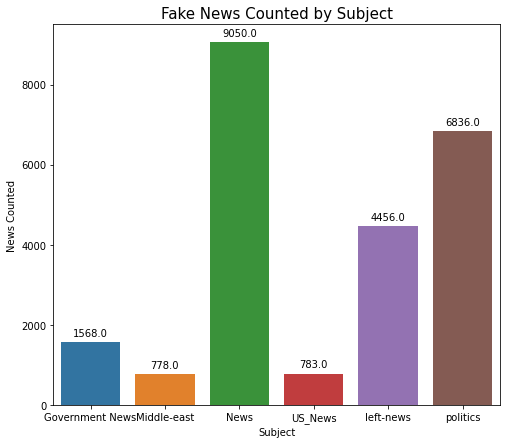

In [ ]:
plt.figure(figsize=(8, 7))
splot=sns.barplot(x="Subject",
                  y="News Counted",
                  data=by_subject[by_subject['Class'] == 0][['Subject', 'News Counted']])
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xlabel("Subject", size=10)
plt.ylabel("News Counted", size=10)
plt.title("Fake News Counted by Subject", size=15)

Text(0.5, 1.0, 'True News Counted by Subject')

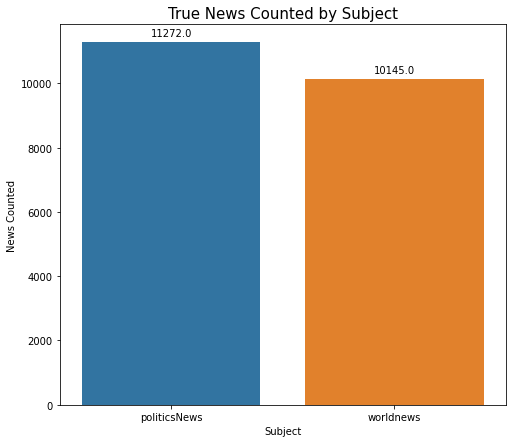

In [ ]:
plt.figure(figsize=(8, 7))
splot=sns.barplot(x="Subject",
                  y="News Counted",
                  data=by_subject[by_subject['Class'] == 1][['Subject', 'News Counted']])
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xlabel("Subject", size=10)
plt.ylabel("News Counted", size=10)
plt.title("True News Counted by Subject", size=15)

#####Subject Perspective

As per results, we could conclude that the fake news only appeared on the news other than the 'politicalNews' and 'worldnews' subjects. The model sure would be improved drastically because of this crystal-clear distinction between subject classes, if we want to build the ensemble model based on this feature.

But if we blankly follow this conclusion, we may have some biases if the model can't handle the testing data out there with different subject classification.

For this dataset, it could be believed that the training, validation, and test data are the same for learning purpose only. Not for the real case.

We could say that the most of the fake news comes from "News", "Politics", and "leftnews" categories. The weight of the model could adjusted more to this categories, for fake news. And "politicNews" & "worldnews" could adjusted more on the true news weight model.

In [ ]:
by_month_year = df.groupby(['month_year', 'class']).count().reset_index(level=['month_year', 'class'])[['month_year', 'class', 'title']]
by_month_year.columns = ['Time', 'Class', 'News Counted']
by_month_year['Time'] = by_month_year['Time'].dt.strftime('%m-%Y')
# time from 2015-03 to 2018-02 (2 years 11 months)
by_month_year.tail(10)

,Time,Class,News Counted
49,08-2017,1,657
50,09-2017,0,636
51,09-2017,1,3074
52,10-2017,0,605
53,10-2017,1,3172
54,11-2017,0,523
55,11-2017,1,3096
56,12-2017,0,447
57,12-2017,1,2533
58,02-2018,0,35


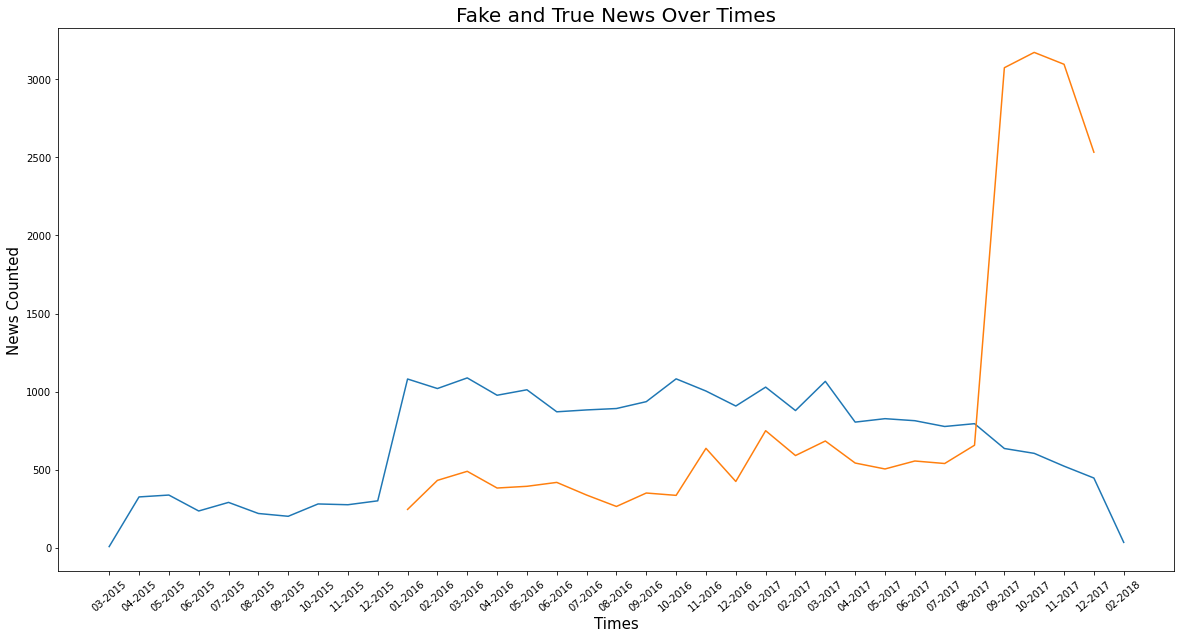

In [ ]:
#looking for trend of fake and true news over times
plt.figure(figsize=(20, 10))
plt.xticks(rotation=40)
plt.title("Fake and True News Over Times", size=20)
plt.xlabel("Times", size=15)
plt.ylabel("News Counted", size=15)
plt.legend(title='Smoker', loc='upper left', labels=['Fake News', 'True News'])
sns.lineplot(data=by_month_year, x="Time", y="News Counted", hue="Class", legend=False)

Based on the graph above, we could conclude that the trends of fake and true news change over time in opposite direction, especially between 06-2017 to 10-2017, before decreased again respectively. The short amount of time from that times must be cause some important event, and the news subject must be some booming stuff on the mass media.

In [ ]:
by_month_year_subject = df.groupby(['month_year', 'subject', 'class']).count().reset_index(level=['month_year', 'subject', 'class'])[['month_year', 'subject', 'class', 'title']]
by_month_year_subject.columns = ['Time', 'Subject', 'Class', 'News Counted']
by_month_year_subject['Time'] = by_month_year_subject['Time'].dt.strftime('%m-%Y')
# time from 2015-03 to 2018-02 (2 years 11 months)
by_month_year_subject.tail(60)

,Time,Subject,Class,News Counted
143,05-2017,News,0,313
144,05-2017,US_News,0,13
145,05-2017,left-news,0,164
146,05-2017,politics,0,274
147,05-2017,politicsNews,1,505
148,06-2017,Government News,0,33
149,06-2017,Middle-east,0,24
150,06-2017,News,0,351
151,06-2017,US_News,0,24
152,06-2017,left-news,0,150


#####Time Perspective

Based on this [source](https://www.infoplease.com/current-events/2017/september-2017-current-events-world-news) there are much news related to the booming count of fake news, especially in west-based news media. Like "London Bombing", "School Fire in Malaysia", "Nuclear Test of North Korea", and so on. This is a piece of that lists.

1.  Kenyan Court Voids Election Results
2.  South Korea and U.S. Revise Defense Treaty
3.  Cambodian Government Cracks Down on Media and Opposition
4.  North Korea Conducts Historic Nuclear Test
5.  Catalonia Begins Bid for Independence
6.  The Philippines Suspends Trade with North Korea
7.  Myanmar Government Rejects ARSA Proposal
8.  30 Injured in Train Collision
9.  Suspected Russian Airstrike in Syria
10. Senator Hontiveros Calls for Aguirre Resignation
11. Norwegian Prime Minister Re-elected
12. 3 Dead in Kabul Bombing
13. Paris to Host 2024 Summer Olympics
14. Multiple ISIL Attacks near Nasiriya
15. 23 Dead in Kuala Lumpur School Fire
16. Injured in London Bombing

Majority of the news came from "News", "World News", "Left News" and "Politics News". As we all could guessed... based media.

#####News Sources

Let's make wordcloud to analyze it in the descriptive way about what words frequently occured in the fake and true news. With some information have obtained before, maybe we could concluded what combination of subjects and news typed that tend to be fake news source.

In [ ]:
texter.str.count('reuters').sum()

22

In [ ]:
#install some neccessaried libraries
!pip install pillow
!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS

In [35]:
#Cleaning column with text data type (for wordcloud preparation)
def preprocess(text):
    text = text.lower()
    text = re.sub('\n', '', text)
    text = re.sub("\\W"," ",text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [63]:
all_title = df.groupby(['class'])['title'].apply(lambda x: " ".join(x)).reset_index()['title']
#while true news class is '1', the grouping result from above code find 
# the '1' class in the first row, so the array slicer of true news' title is '0' 
true_title = preprocess(all_title[0])
fake_title = preprocess(all_title[1])

In [64]:
#making wordcloud for "title" text
stopwords = set(STOPWORDS)
#update the stopword based on the observation on the loanwords appeared in the trial wordcloud
stopwords.update(["back", "call", "day", "despite", "even", "first" "make", "may", "need", "new", "put", "say", "says", "take", "tell", "told", "used", "way", "will", "want", "watch", "video"])

fake_title_wc = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    collocations = True,
    stopwords = stopwords
).generate(fake_title)

true_title_wc = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    collocations = True,
    stopwords = stopwords
).generate(true_title)

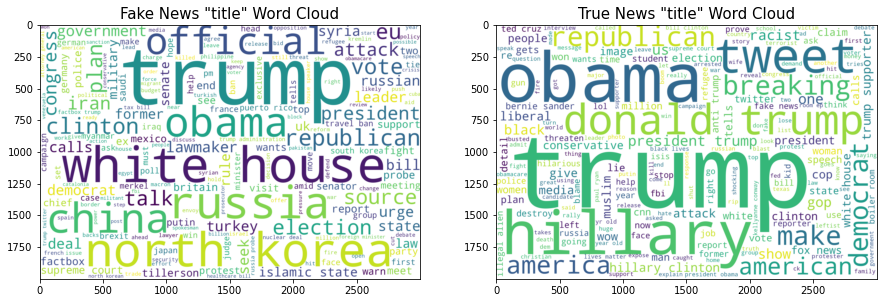

In [65]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
# fig.suptitle('Word Cloud of Fake and True News Text', fontsize=18)
ax1.title.set_text('Fake News "title" Word Cloud')
ax2.title.set_text('True News "title" Word Cloud')
ax1.title.set_size(15)
ax2.title.set_size(15)
ax1.imshow(fake_title_wc, interpolation="bilinear")
ax2.imshow(true_title_wc, interpolation="bilinear")

As we can see on the wordcloud images above, the fake news mostly came from news with titles are all about foreign countries situations or USA affairs with other countries like "China", "Russia", "Iran", "Syria" and "North Korea". Could we agree that USA itself spread more rumors or disinformation to their foe while being the peacemaker country (?) 

The true news itself mostly came from the USA internal affairs, and most of them are all about politic situations in USA like "Obama", "Trump", "Hillary", "Campaign on Twitter", "Republic Party", or "Democrat Party".

In [66]:
all_text = df.groupby(['class'])['text'].apply(lambda x: " ".join(x)).reset_index()['text']
true_text = preprocess(all_text[0])
fake_text = preprocess(all_text[1])

In [73]:
#making wordcloud for "text" text
stopwords = set(STOPWORDS)
#update the stopword based on the observation on the loanwords appeared in the trial wordcloud
#too much loan words or html-crawled button texts from the news portals
#must tokenize the words and post-tag it to remove all except 'Noun'
#for the future, it is recommended to use "spacy" library to remove all loanwords in this context
stopwords.update(["according",
                  "already",
                  "back",
                  "believe", 
                  "call",
                  "called",
                  "came",
                  "co",
                  "come",
                  "day",
                  "despite",
                  "even",
                  "featured",
                  "first",
                  "give",
                  "given",
                  "going",
                  "https",
                  "image",
                  "including",
                  "issue",
                  "last",
                  "last week",
                  "last year",
                  "made",
                   "make",
                  "many",
                   "may",
                  "mean",
                  "monday",
                  "much",
                   "need",
                   "new",
                  "next",
                  "now",
                   "one",
                  "part",
                  "people",
                  "previous",
                   "put",
                  "read",
                   "said",
                  "saturday",
                   "say",
                   "says",
                  "saying",
                  "something"
                   "statement",
                  "still",
                  "sunday",
                   "take",
                   "tell",
                  "thing",
                  "thursday",
                  "time",
                  "today",
                   "told",
                  "tuesday",
                   "used",
                  "want",
                  "watch",
                   "way",
                  "wednesday",
                  "week",
                  "well",
                   "will",
                  "work",
                   "video",
                  "year"])

fake_text_wc = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    collocations = True,
    stopwords = stopwords
).generate(fake_text)

true_text_wc = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    collocations = True,
    stopwords = stopwords
).generate(true_text)

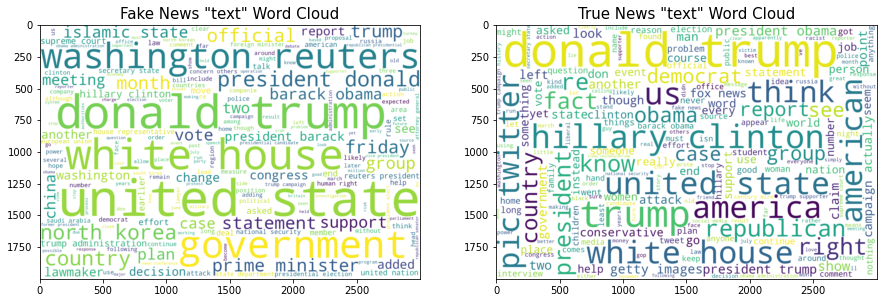

In [74]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
# fig.suptitle('Word Cloud of Fake and True News Text', fontsize=18)
ax1.title.set_text('Fake News "text" Word Cloud')
ax2.title.set_text('True News "text" Word Cloud')
ax1.title.set_size(15)
ax2.title.set_size(15)
ax1.imshow(fake_text_wc, interpolation="bilinear")
ax2.imshow(true_text_wc, interpolation="bilinear")

The result seems correlated with the title (of course), because the fake news wordcloud showed above have same main words, like North Korea, China, IS(Islamic State), and so on. 

But if we focus on the news sources, we could see that "Reuters" is the most news source that tend to make more fake news. As same as the word cloud of true news' title, the texts of true news contains political situations on USA in 2017-2018 for presidential election. Butif we look carefully, there's "Fox News" word appear on the image, but the news source mainly came from "Twitter" platform.